# Lecture 11
_____________


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
import cvxpy as cvx

## _Reservoir control - Folsom_


In [28]:
Q = np.loadtxt('data/FOL-monthly-inflow-TAF.csv', delimiter=',', skiprows=1, usecols=[1]) # vector of inflows

T = len(Q) # number of timesteps in inflow series
K = 975 # reservoir capacity
x = cvx.Variable(T+1) # storage vector (decision variable)
u = cvx.Variable(T) # release vector (decision variable)
d = 150*np.ones(T) # target demand (TAF/month) - 5 TAF/day; assumed constant here

__Objective function__: The choice of objective function will reflect the preference between the frequency and volume of shortages. The squared deficit is often used to represent shortage cost.

In [29]:
obj = cvx.Minimize(cvx.sum((cvx.pos(d - u))**2)) # sum squared deficit (vector form)

__Constraints__ (define separately, then concatenate the lists)

The constraints can apply to either the entire vector, or specific elements

In [34]:
c_mass_balance = [x[1:] == x[:-1] - u + Q] # state transition (mass balance)
c_release = [u >= 0] # release lower/upper bounds
c_storage = [x >= 0, x <= K] # storage lower/upper bounds
c_init_final = [x[0] == K/2, x[T] >= 200] # initial/final storage values
constraints = c_mass_balance + c_release + c_storage + c_init_final # concatenated list

In [35]:
prob = cvx.Problem(obj, constraints)
prob.solve() # run optimization

68973.34771980901

In [36]:
print('Status: %s' % prob.status)
print('Obj Fun: %f' % obj.value)

Status: optimal
Obj Fun: 68973.347720


All plotting below here:

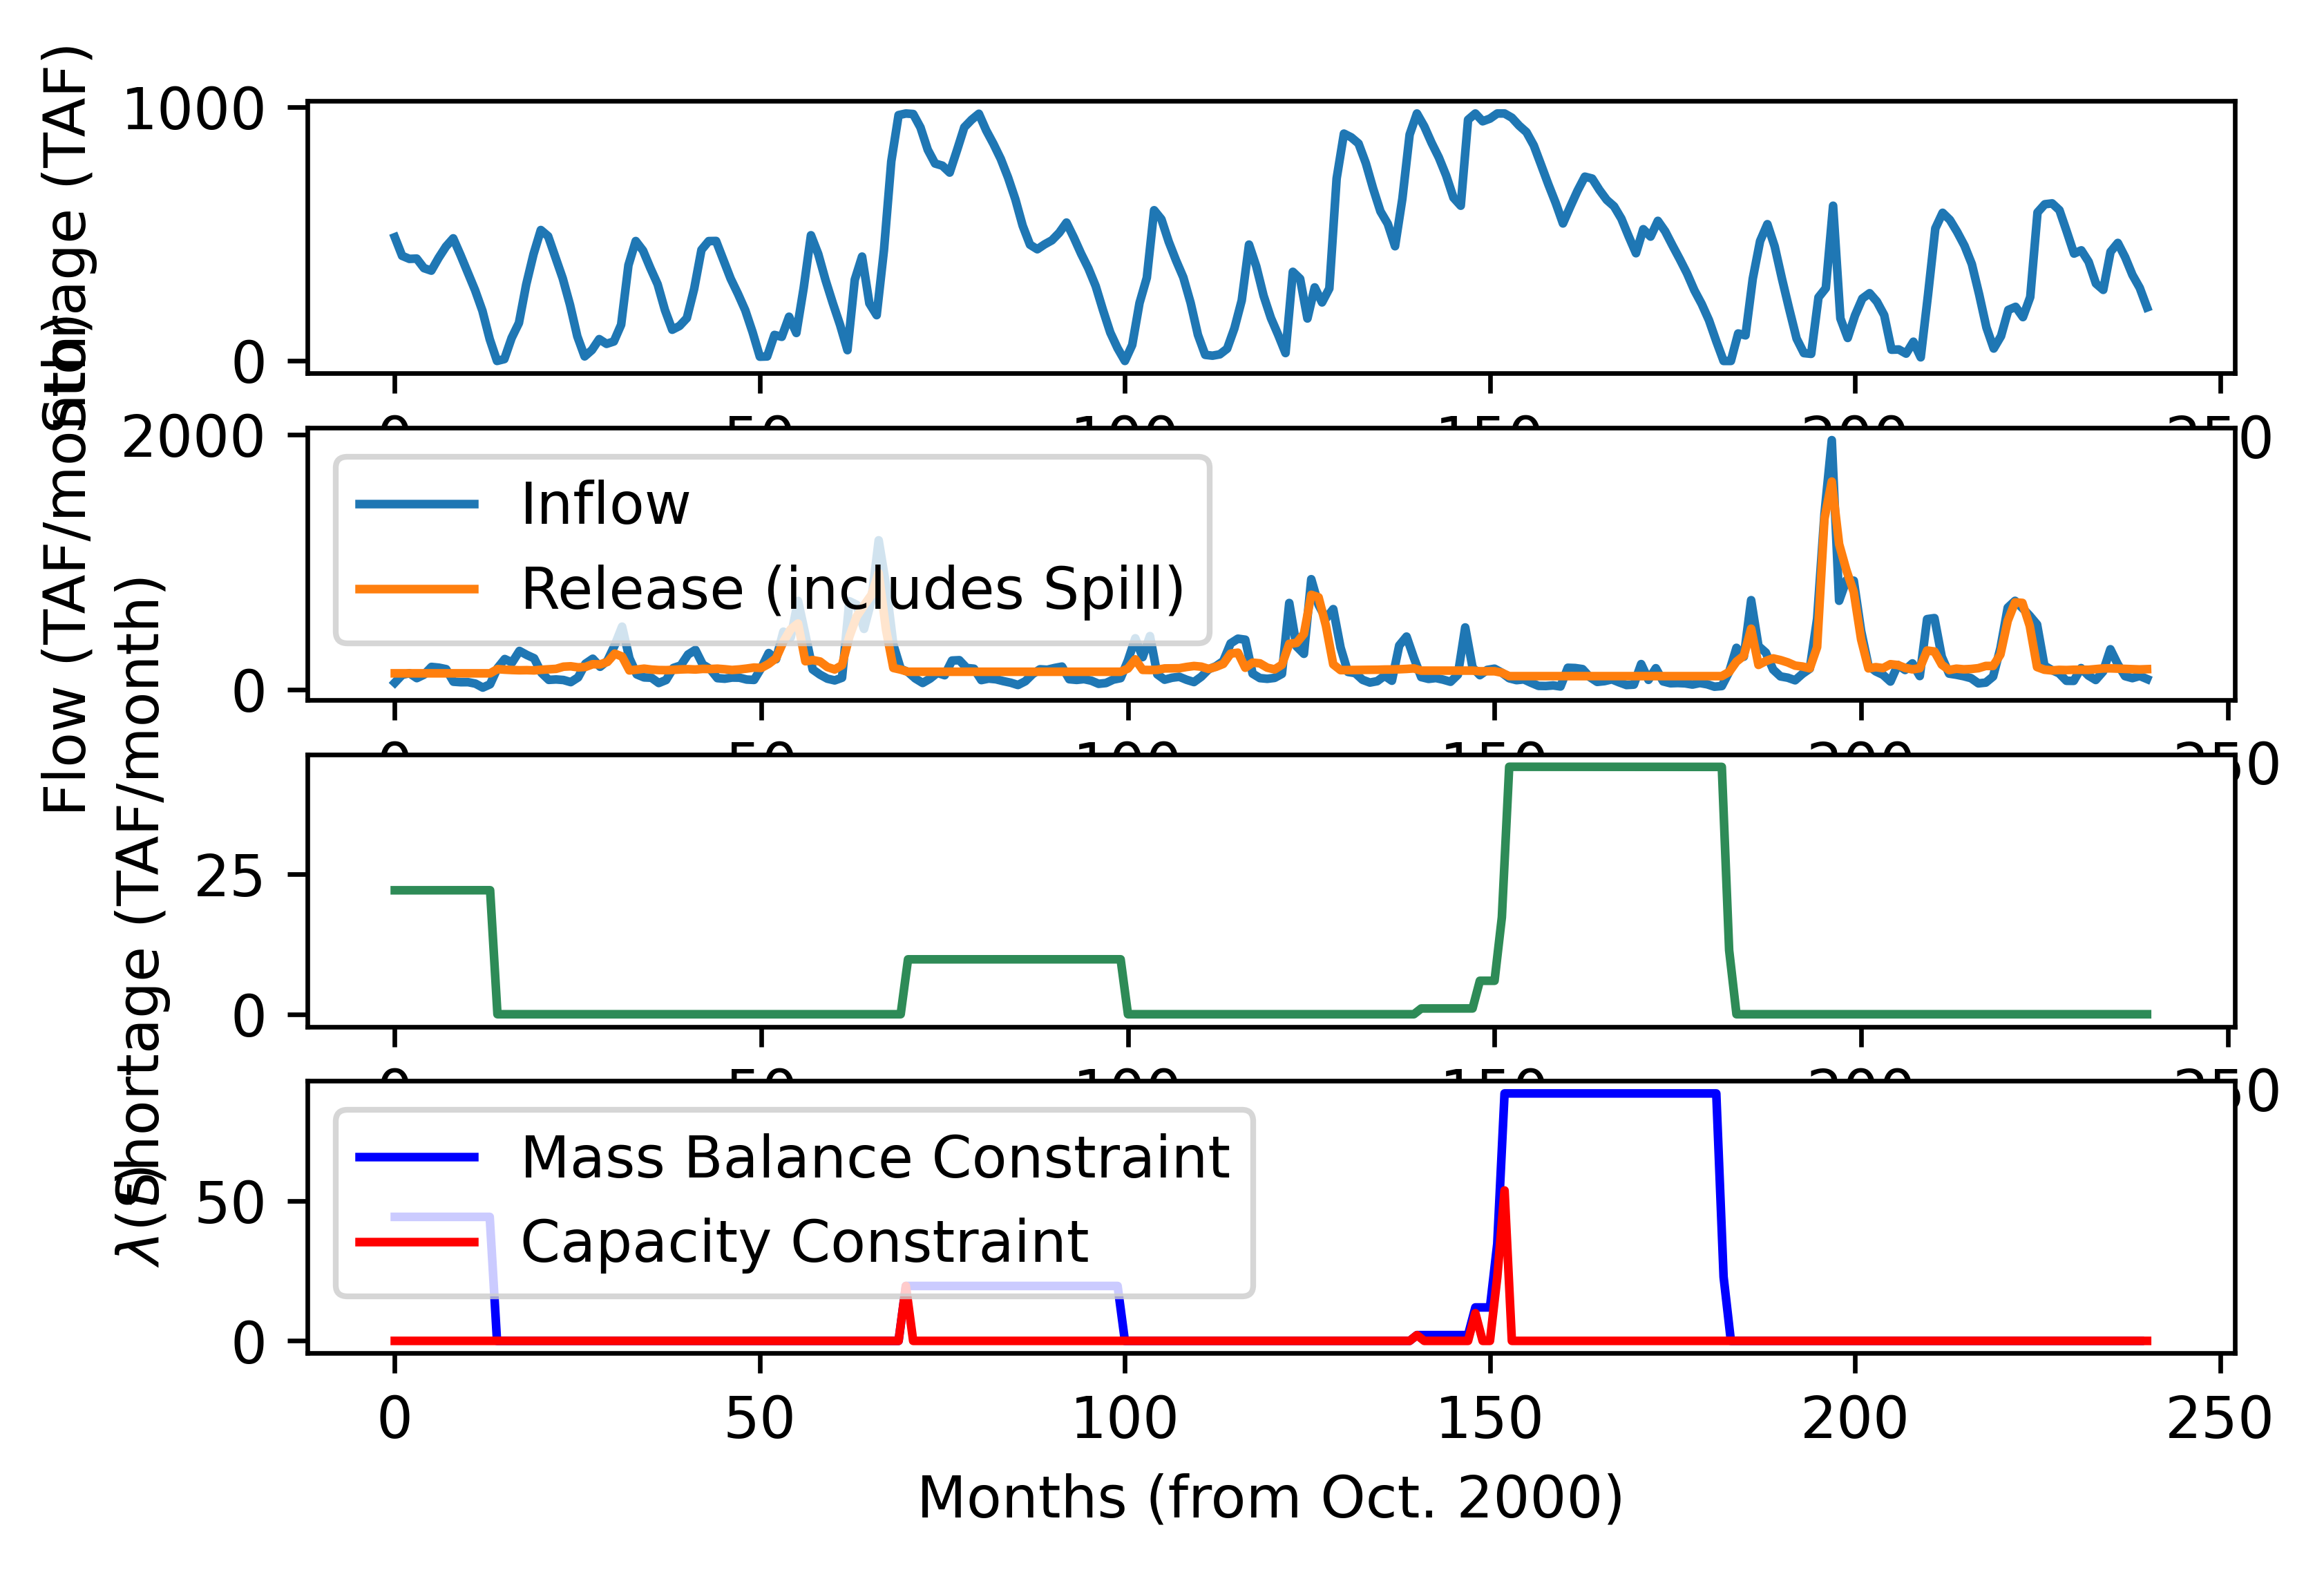

In [37]:
plt.subplot(4,1,1)
plt.plot(x.value)
plt.ylabel('Storage (TAF)')

plt.subplot(4,1,2)
plt.plot(Q)
plt.plot(u.value)
plt.legend(['Inflow', 'Release (includes Spill)'])
plt.ylabel('Flow (TAF/month)')

plt.subplot(4,1,3)
shortage = (d-u.value) 
shortage[shortage < 0] = 0 # we only track positive shortages
plt.plot(shortage, color='seagreen')
plt.ylabel('Shortage (TAF/month)')

# Dual values (lambda); constraints[] list in the same order as defined above
plt.subplot(4,1,4)
plt.plot(constraints[0].dual_value, color='blue') # mass balance constraint
plt.plot(constraints[3].dual_value, color='red') # capacity constraint
plt.ylabel(r'$\lambda(t)$')
plt.legend(['Mass Balance Constraint', 'Capacity Constraint'], loc=2)
plt.xlabel('Months (from Oct. 2000)')

plt.show()